# Online Retail Customer Segmentation

## Project Goal

The primary goal of this project is to segment customers of an online retail store into distinct groups based on their purchasing behavior (Recency, Frequency, Monetary - RFM) using K-Means clustering. This segmentation aims to enable more targeted and effective marketing strategies.

## Problem Statement

In the competitive online retail landscape, understanding customer behavior is crucial for business growth and profitability. A common challenge is that marketing efforts are often applied uniformly across all customers, leading to inefficient resource allocation and suboptimal engagement. Without clear customer segments, it's difficult to:
* Identify high-value customers who deserve special attention.
* Recognize at-risk customers who might churn.
* Tailor product recommendations or promotional offers effectively.

This project addresses this problem by applying unsupervised machine learning to uncover natural groupings within the customer base. By segmenting customers, we aim to provide actionable insights that can inform personalized marketing campaigns, improve customer retention, and optimize overall marketing spend.

## 1. Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

## 2. Data Loading and Initial EDA

In [2]:
# --- Data Loading ---
try:
    df_unprocessed = pd.read_csv('D:/Downloads/OnlineRetail/OnlineRetail.csv', encoding='latin1')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'Online Retail.csv' not found.")
    exit() # Exit if the file is not found

df = df_unprocessed.copy()   # work on copied dataset

Dataset loaded successfully.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


- Online Retail daset consists total `541909` entries.
- `CustomerID` is `float64` with 406829 non-null entries out of 541909 total. This clearly shows the presence of NaN (Not a Number) values.
- `InvoiceDate` is `object`. This means it's currently stored as a string and will correctly be converted to datetime in the data preprocessing section.

In [4]:
# --- statistical summary of numerical features ---
df.drop('CustomerID', axis=1).describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


- The standard deviation of both `Quantity (218.08)` and `UnitPrice (96.76)` is very high. This is a strong indicator of **high variance** and the presence of **outliers**. A large standard deviation relative to the mean suggests that data points are widely spread out from the average.
- The median (50%) `Quantity is 3 units`. This is significantly lower than the `mean (9.55)`, which further confirms the **right-skewness** of the distribution. The mean is pulled up by a few very large positive quantities.
- The median `UnitPrice is 2.08`. Again, this is significantly lower than the `mean (4.61)`, indicating a **strong right-skewness** due to a few very expensive items.
- The minimum `Quantity` is `-80,995`. A negative quantity typically represents **returned items** or credit notes in this dataset. For customer segmentation based on purchasing behavior, these negative values are usually removed as they don't represent a "purchase."
- The minimum `UnitPrice` is `-11,062.06`. A negative unit price is highly unusual and likely indicates a **data error**, a special type of credit, or a very large refund. These values are typically removed or handled during preprocessing.

#### **Conclusion:**

This descriptive statistics output strongly justifies the following:

* **Filtering for `Quantity > 0` and `UnitPrice > 0`:** This is essential to remove the negative and zero values, which are either returns or data errors, and to ensure that our RFM calculations are based on valid sales transactions.
* **Log Transformation for Visualization:** The extreme skewness and presence of outliers (as evidenced by the large difference between mean/median and the min/max values) make the raw distributions difficult to visualize. Log transformation is necessary to make these plots interpretable.

In [5]:
# ---statistical Summary of categorical Features ---
df.select_dtypes(include='object').describe()

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,10/31/2011 14:41,United Kingdom
freq,1114,2313,2369,1114,495478


In [6]:
print("\n Statistical Summary of Categorical Features:")
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    print(f"\nColumn: '{col}'")
    print(f"  Number of unique values: {df[col].nunique()}")
    print(f"  Top 5 most frequent values:")
    print(df[col].value_counts(dropna=False))
    print("-" * 30)    


 Statistical Summary of Categorical Features:

Column: 'InvoiceNo'
  Number of unique values: 25900
  Top 5 most frequent values:
InvoiceNo
573585     1114
581219      749
581492      731
580729      721
558475      705
           ... 
581483        1
581566        1
C581499       1
C536383       1
C536379       1
Name: count, Length: 25900, dtype: int64
------------------------------

Column: 'StockCode'
  Number of unique values: 4070
  Top 5 most frequent values:
StockCode
85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
          ... 
85179a       1
23617        1
90214U       1
47591b       1
72802c       1
Name: count, Length: 4070, dtype: int64
------------------------------

Column: 'Description'
  Number of unique values: 4223
  Top 5 most frequent values:
Description
WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED

## 3. Data Preprocessing

In [7]:
# Drop rows with missing CustomerID, as it's essential for segmentation
df.dropna(subset=['CustomerID'], inplace=True)
print(f"Shape after dropping missing CustomerID: {df.shape}")

Shape after dropping missing CustomerID: (406829, 8)


In [8]:
# Remove canceled orders (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C', na=False)]
print(f"Shape after removing canceled orders: {df.shape}")

Shape after removing canceled orders: (397924, 8)


In [9]:
# Convert InvoiceDate to datetime objects
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [10]:
# Calculate TotalPrice for each item
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [11]:
# Filter out rows with negative or zero Quantity/UnitPrice (data inconsistencies)
# This step is crucial before log transformation
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
print(f"Shape after filtering invalid quantities/prices: {df.shape}")

Shape after filtering invalid quantities/prices: (397884, 9)


## 4. EDA on Processed data

In [12]:
# --- Display basic information about the DataFrame after preprocessing ---
print("\n1. DataFrame Info preprocessing:")
df.info()


1. DataFrame Info preprocessing:
<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
 8   TotalPrice   397884 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.4+ MB


In [13]:
# --- Check for missing values (should be none after preprocessing for CustomerID) ---
print("\nMissing Values (after preprocessing):")
df.isnull().sum()


Missing Values (after preprocessing):


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64


Distribution of Quantity, UnitPrice and TotalPrice (using log transformation for better visibility):


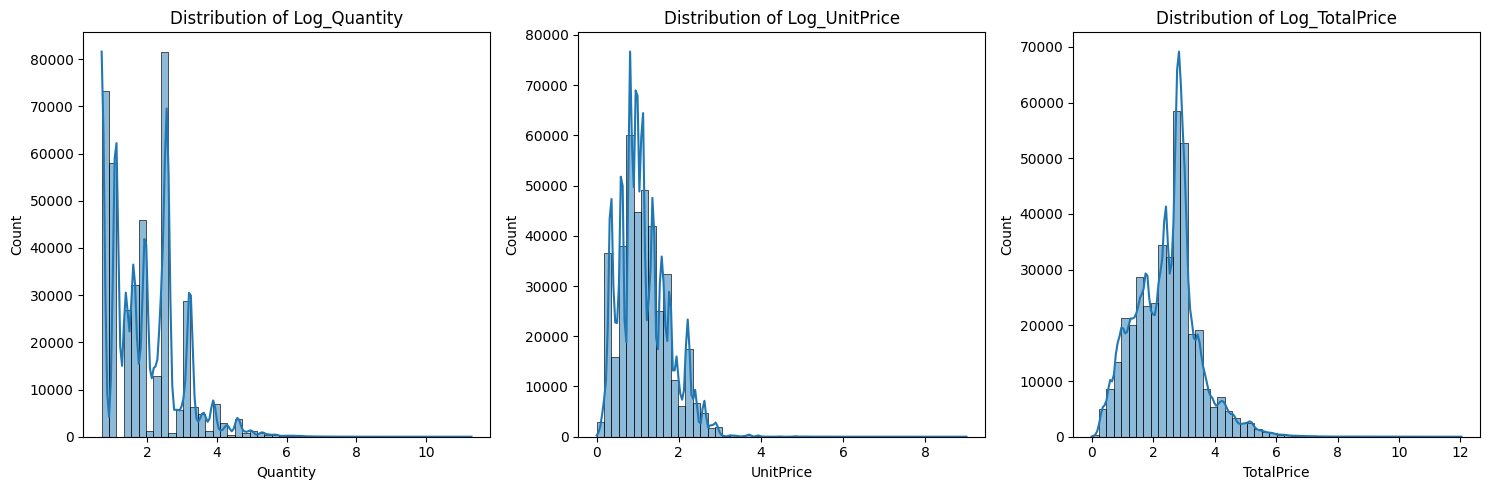

In [14]:
print("\nDistribution of Quantity, UnitPrice and TotalPrice (using log transformation for better visibility):")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1) # 1 row, 3 columns, 1st plot
sns.histplot(np.log1p(df['Quantity']), bins=50, kde=True)
plt.title('Distribution of Log_Quantity')
plt.xlabel('Quantity')
plt.ylabel('Count')


plt.subplot(1, 3, 2) # 1 row, 3 columns, 2nd plot
sns.histplot(np.log1p(df['UnitPrice']), bins=50, kde=True,)
plt.title('Distribution of Log_UnitPrice')
plt.xlabel('UnitPrice')
plt.ylabel('Count')

plt.subplot(1, 3, 3) # 1 row, 3 columns, 3rd plot
sns.histplot(np.log1p(df['TotalPrice']), bins=50, kde=True,)
plt.title('Distribution of Log_TotalPrice')
plt.xlabel('TotalPrice')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

#### **Interpretation for Each Plot:**
1. **Distribution of Log_Quantity**
    - **Shape:** The distribution is still somewhat right-skewed, but it's far more spread out than the raw Quantity plot. There's a prominent peak around 1.0 to 2.0 on the log scale, indicating that the most common quantities are relatively small (since $e^1≈2.7$ and $e^2≈7.4$).

    - **Interpretation:** This suggests that customers most frequently purchase small numbers of items per transaction. The tail extending to the right indicates that while less common, there are still transactions with higher quantities, which are now visible on the plot.

2. **Distribution of Log_UnitPrice**
    - **Shape:** Similar to Log_Quantity, this distribution is also more spread out and shows a clear peak. The peak appears to be around 0.5 to 1.5 on the log scale, meaning the most common unit prices are quite low (since $e^{0.5}≈1.6$ and $e^{1.5}≈4.5$).

    - **Interpretation:** This signifies that the majority of individual items sold in the online retail store are inexpensive. The right tail shows that there are also more expensive items, but they are less frequent.

3. **Distribution of Log_TotalPrice**
    - **Shape:** This plot also shows a much clearer, more symmetrical (though still slightly right-skewed) distribution compared to what raw TotalPrice would look like. There's a distinct peak, likely around 2.0 to 3.0 on the log scale (meaning total prices are commonly between $e^2≈7.4$ and $e^3≈20$).

    - **Interpretation:** This represents the total value of individual transactions. The peak indicates the most common transaction values, and the spread shows the range of spending per invoice after cleaning. This distribution is crucial because TotalPrice is directly used to derive the Monetary value in our RFM analysis.

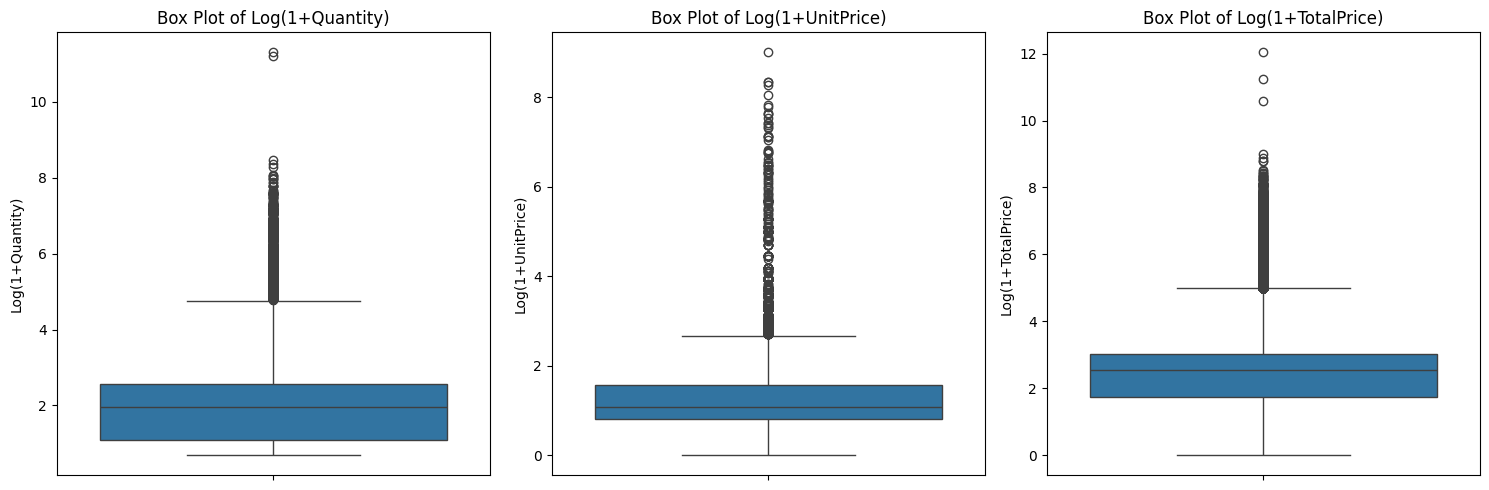

In [15]:
# Box plots to visualize outliers in Quantity, UnitPrice and TotalPrice (Using log transformation)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(y=np.log1p(df['Quantity']))
plt.title('Box Plot of Log(1+Quantity)')
plt.ylabel('Log(1+Quantity)')

plt.subplot(1, 3, 2)
sns.boxplot(y=np.log1p(df['UnitPrice']))
plt.title('Box Plot of Log(1+UnitPrice)')
plt.ylabel('Log(1+UnitPrice)')

plt.subplot(1, 3, 3)
sns.boxplot(y=np.log1p(df['TotalPrice']))
plt.title('Box Plot of Log(1+TotalPrice)')
plt.ylabel('Log(1+TotalPrice)')

plt.tight_layout()
plt.show()

#### **Interpretation for Each BoxPlot:**
1. **Box Plot of Log(1+Quantity)**
    - **Median (the line inside the box):** Appears to be around 1.5 - 2.0. This means the typical (median) Log(1+Quantity) is in this range.

    - **Interquartile Range (IQR - the box itself):** The box spans from approximately 1.0 to 2.5. This indicates that 50% of the Log(1+Quantity) values fall within this relatively narrow range.

    - **Whiskers:** The whiskers extend to capture most of the data.

    - **Outliers (individual points above the top whisker):** There are still a number of individual points extending upwards, particularly a noticeable cluster around 8.0 and a few higher ones. These correspond to transactions with exceptionally large quantities, even after the log transformation.

    - **Interpretation:** The majority of transactions involve small quantities, but there's a long tail of increasingly larger quantities, which are still considered outliers even on a log scale. This confirms the highly skewed nature of quantity data.

2. **Box Plot of Log(1+UnitPrice)**
    - **Median:** Appears to be around 0.5 - 1.0. This suggests that the typical (median) Log(1+UnitPrice) is quite low.

    - **Interquartile Range (IQR):** The box spans roughly from 0.0 to 1.5. This shows that 50% of the Log(1+UnitPrice) values are concentrated in this low range.

    - **Whiskers:** Similar to Quantity, the whiskers cover most of the common data.

    - **Outliers:** This plot shows a very dense cluster of outliers extending significantly upwards, reaching values above 8.0. This indicates that while most items are inexpensive, there's a substantial number of items with much higher unit prices, leading to a long tail of outliers.

    - **Interpretation:** The vast majority of items sold are low-priced, but there's a significant presence of higher-priced items that are outliers even after transformation. This is a characteristic of many retail businesses where a few premium items coexist with many everyday low-cost items.

3. **Box Plot of Log(1+TotalPrice)**
    - **Median:** Appears to be around 2.0 - 2.5.

    - **Interquartile Range (IQR):** The box spans roughly from 1.5 to 3.0.

    - **Whiskers:** The whiskers extend to cover the bulk of the data.

    - **Outliers:** Similar to Log(1+UnitPrice), there's a clear upward spread of outliers, reaching values above 10.0. These represent transactions with very high total values.

    - **Interpretation:** While most transactions have a moderate total value, there are a considerable number of transactions with significantly higher total spending. This is a direct consequence of the distributions of Quantity and UnitPrice, as TotalPrice is their product.

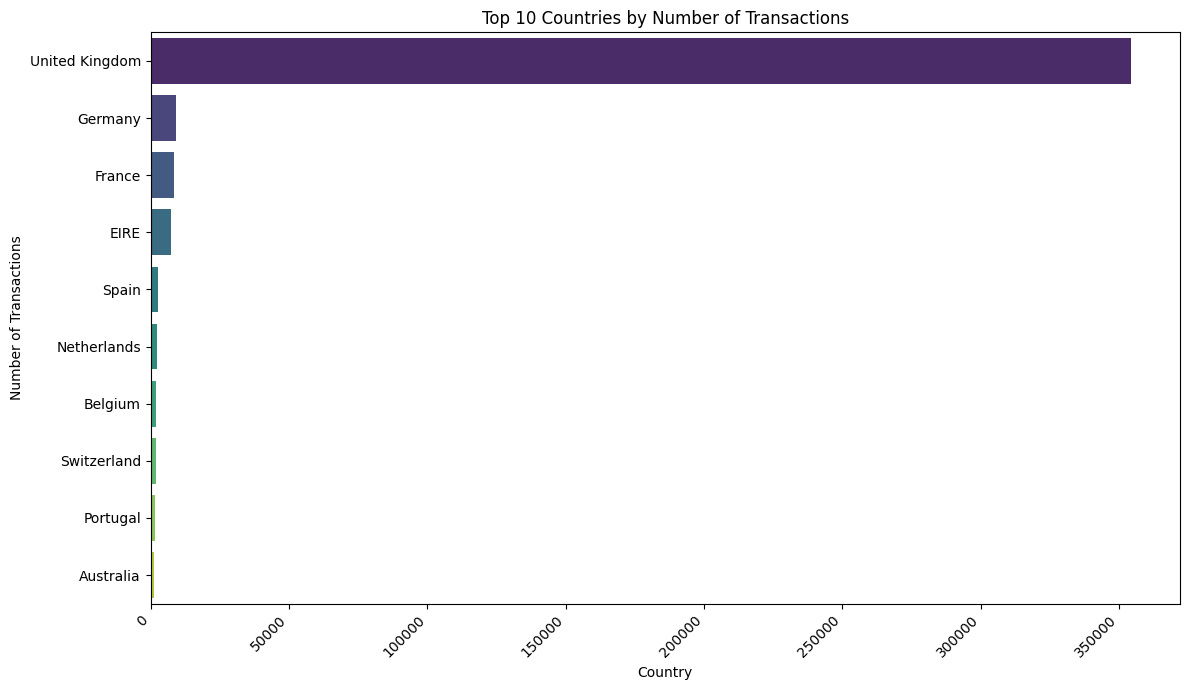

In [16]:
# Top 10 Countries by number of transactions (categorical feature)
# First, count transactions per country
country_counts = df['Country'].value_counts().head(10)

plt.figure(figsize=(12, 7))
sns.barplot(y=country_counts.index, x=country_counts.values, hue=country_counts.index, legend=False, palette='viridis')
plt.title('Top 10 Countries by Number of Transactions')
plt.xlabel('Country')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45, ha='right') # Rotate labels for readability
plt.tight_layout()
plt.show()

In [18]:
pd.DataFrame({'Country':country_counts.index, 'Number of Transactions': country_counts.values})

,Country,Number of Transactions
0,United Kingdom,354321
1,Germany,9040
2,France,8341
3,EIRE,7236
4,Spain,2484
5,Netherlands,2359
6,Belgium,2031
7,Switzerland,1841
8,Portugal,1462
9,Australia,1182


## 5. RFM Feature Engineering

In [19]:
print("\n--- RFM Feature Engineering ---")
# Define a snapshot date for Recency calculation.
# We'll choose one day after the last transaction in the dataset to ensure all recency values are positive.
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calculate RFM metrics
rfm = df.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda date: (snapshot_date - date.max()).days), # Days since last purchase
    Frequency=('InvoiceNo', 'nunique'),                                    # Number of unique purchases
    Monetary=('TotalPrice', 'sum')                                         # Total spending
).reset_index()

print("\nRFM DataFrame Head:")
rfm.head(10)


--- RFM Feature Engineering ---

RFM DataFrame Head:


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40
5,12352.0,36,8,2506.04
6,12353.0,204,1,89.00
7,12354.0,232,1,1079.40
8,12355.0,214,1,459.40
9,12356.0,23,3,2811.43


In [20]:
# shape of the RFM dataframe
print("\nShape of RFM Data Frame:")
print(rfm.shape)


Shape of RFM Data Frame:
(4338, 4)


In [21]:
print("\nRFM DataFrame Description:")
rfm.drop('CustomerID', axis=1).describe()


RFM DataFrame Description:


,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2054.266460
std,100.014169,7.697998,8989.230441
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,307.415000
50%,51.000000,2.000000,674.485000
75%,142.000000,5.000000,1661.740000
max,374.000000,209.000000,280206.020000


#### **Interpretation of `rfm.describe()` for Recency, Frequency, and Monetary**
1. **General Observation:**
    - **count (4338.0):** This tells us that after all the preprocessing (dropping missing CustomerIDs, removing canceled orders, and filtering for positive Quantity/UnitPrice), there are 4,338 unique customers in our dataset. This is the number of data points we will be clustering.
  
2. **Interpretation for Recency:**
    - **mean (92.54):** On average, a customer's last purchase was about 92.5 days ago.

    - **std (100.01):** The standard deviation is quite large (100 days), indicating a wide spread in how recently customers have purchased.

    - **min (1.0):** The most recent purchase by any customer was 1 day ago (as designed by our `snapshot_date` calculation). This means we have very active, fresh customers.

    - **25% (18.0):** 25% of customers made their last purchase within 18 days. These are our most recent customers.

    - **50% (median) (51.0):** Half of our customers made their last purchase within 51 days. The median is significantly lower than the mean, suggesting a right-skewed distribution (many customers purchased recently, but a tail of customers purchased a long time ago).

    - **75% (142.0):** 75% of customers made their last purchase within 142 days.

    - **max (374.0):** The least recent purchase by any customer was 374 days ago. This is close to a year, indicating some customers have been inactive for a long time.
  
    - **Summary for Recency:** The distribution is right-skewed, with a good portion of customers being relatively recent (within 1-2 months), but also a significant number who haven't purchased for several months. This skewness is important for clustering, as it will likely define distinct segments.
  
3. **Interpretation for Frequency:**
    - **mean (4.27):** On average, customers have made about 4.27 unique purchases.

    - **std (7.70):** The standard deviation is relatively high compared to the mean, again suggesting a **skewed distribution** and the presence of customers who purchase very frequently.

    - **min (1.0):** The minimum frequency is 1, meaning every customer in this dataset has made at least one purchase.

    - **25% (1.0):** 25% of customers have made only 1 unique purchase. This indicates a large segment of one-time buyers.

    - **50% (median) (2.0):** Half of our customers have made 2 or fewer unique purchases. The median is much lower than the mean, confirming a **strong right-skewness**.

    - **75% (5.0):** 75% of customers have made 5 or fewer unique purchases.

    - **max (209.0):** The maximum frequency is 209, indicating a highly frequent, loyal customer (an **outlier**).

    - **Summary for Frequency:** The distribution is heavily right-skewed, with most customers making only a few purchases, but a small group of highly frequent buyers.
  
4. **Interpretation for Monetary:**
    - **mean (2054.27):** On average, a customer has spent about £2054.27.

    - **std (8989.23):** The standard deviation is extremely high (almost 9000!) compared to the mean. This is a very strong indicator of **extreme right-skewness** and the presence of very large **outliers**.

    - **min (3.75):** The minimum total spending by a customer is £3.75.

    - **25% (307.42):** 25% of customers have spent £307.42 or less.

    - **50% (median) (674.49):** Half of our customers have spent £674.49 or less. The median is significantly lower than the mean, reinforcing the severe **right-skewness**.

    - **75% (1661.74):** 75% of customers have spent £1661.74 or less.

    - **max (280206.02):** The maximum total spending by a single customer is an enormous £280,206.02. This is a massive **outlier** that pulls the mean up dramatically.

    - **Summary for Monetary:** The Monetary distribution is severely **right-skewed**. Most customers spend relatively small amounts, but there are a few "whale" customers who spend exceptionally large sums, acting as significant **outliers**.

#### **Implications for the Next Steps (Outlier Treatment and Scaling):**

1. **Outlier Treatment (Capping):** The `max` values for all three (especially Monetary) are vastly different from their 75th percentiles, confirming the presence of extreme outliers. Capping these outliers (we will do in the next step using 5th and 95th percentiles) is essential to prevent them from disproportionately influencing the K-Means clustering algorithm.

2. **Feature Scaling:** The scales of Recency (tens to hundreds), Frequency (single digits to hundreds), and Monetary (hundreds to hundreds of thousands) are vastly different. `StandardScaler` will normalize these scales, ensuring that no single feature dominates the distance calculations during clustering.

## 6. Outlier Treatment for RFM Features

In [22]:
# Outliers can significantly skew clustering results. We'll use capping.
print("\n--- Outlier Treatment (Capping) ---")
for col in ['Recency', 'Frequency', 'Monetary']:
    Q1 = rfm[col].quantile(0.05) # Using 5th percentile for lower bound
    Q3 = rfm[col].quantile(0.95) # Using 95th percentile for upper bound
    rfm[col] = np.where(rfm[col] < Q1, Q1, rfm[col])
    rfm[col] = np.where(rfm[col] > Q3, Q3, rfm[col])
print("RFM outliers capped at 5th and 95th percentiles.")
print("\nRFM DataFrame Description after capping:")
rfm.describe()


--- Outlier Treatment (Capping) ---
RFM outliers capped at 5th and 95th percentiles.

RFM DataFrame Description after capping:


,CustomerID,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,90.837713,3.607653,1313.300421
std,1721.808492,95.547493,3.358326,1526.185801
min,12346.000000,3.000000,1.000000,112.309500
25%,13813.250000,18.000000,1.000000,307.415000
50%,15299.500000,51.000000,2.000000,674.485000
75%,16778.750000,142.000000,5.000000,1661.740000
max,18287.000000,312.000000,13.000000,5841.843000


#### **Capping's Impact:**

The capping at the 5th and 95th percentiles has successfully **reduced the influence of extreme outliers** in our RFM features, particularly for `Frequency` and `Monetary`. The distributions are now less skewed (though still not perfectly normal) and the `mean` and `standard deviation` are more robust and representative of the typical customer.

This modified RFM DataFrame is now much better prepared for the **Feature Scaling** step, and subsequently, for the **K-Means Clustering** algorithm, as the distances between data points will be less distorted by a few extreme values.

## 7. Feature Scaling

In [23]:
# Scaling is crucial for distance-based algorithms like K-Means.
# We'll scale the RFM features.
print("\n--- Feature Scaling ---")
rfm_scaled = rfm[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
rfm_scaled_data = scaler.fit_transform(rfm_scaled)
rfm_scaled_df = pd.DataFrame(rfm_scaled_data, columns=rfm_scaled.columns, index=rfm_scaled.index)
print("RFM features scaled using StandardScaler.")
print("\nScaled RFM DataFrame Head:")
rfm_scaled_df.head(10)


--- Feature Scaling ---
RFM features scaled using StandardScaler.

Scaled RFM DataFrame Head:


,Recency,Frequency,Monetary
0,2.314951,-0.776564,2.967571
1,-0.919415,1.010247,1.963748
2,-0.165777,0.116842,0.317127
3,-0.751940,-0.776564,0.291118
4,2.294017,-0.776564,-0.641477
5,-0.573998,1.308048,0.781607
6,1.184493,-0.776564,-0.787014
7,1.477575,-0.776564,-0.153276
8,1.289165,-0.776564,-0.559564
9,-0.710071,-0.180960,0.981730


## 8. Determining Optimal Number of Clusters

#### **Elbow Method and Silhouette Score:**

The Elbow Method and Silhouette Score are two common techniques used to determine the optimal number of clusters (often denoted as 'k') for clustering algorithms like K-Means.

1. **Elbow Method**
    - **Concept:** The Elbow Method looks for a point of inflection (an "elbow") in a plot of the Within-Cluster Sum of Squares (WCSS) against the number of clusters (k).

    - **WCSS (Within-Cluster Sum of Squares):** This metric calculates the sum of the squared distances between each point and the centroid of its assigned cluster. The goal of K-Means is to minimize WCSS.

    - **How it works:** As we increase the number of clusters (k), the WCSS will naturally decrease (because data points will be closer to their own cluster centroids). However, at some point, adding more clusters will provide diminishing returns, meaning the decrease in WCSS will slow down significantly. This "elbow" point is often considered the optimal 'k' because it represents a good balance between minimizing WCSS and not having too many clusters.

    - **Interpretation:** We plot WCSS on the y-axis and 'k' on the x-axis. Look for the "bend" in the arm of the plot where the rate of decrease sharply changes.
  
2. **Silhouette Score**
    - **Concept:** The Silhouette Score measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). It ranges from -1 to +1.

    - **Calculation:** For each data point, the silhouette score is calculated based on:

        * `a`: The average distance from that point to all other points in the same cluster.

        * `b`: The minimum average distance from that point to all points in a different cluster (the nearest cluster).

        * `Score = (b - a) / max(a, b)`

    - **Interpretation:**

        * **+1:** Indicates that the data point is well-matched to its own cluster and poorly matched to neighboring clusters. This is ideal.

        * **0:** Suggests that the data point is on or very close to the decision boundary between two clusters.

        * **-1:** Means the data point is likely assigned to the wrong cluster.

    - **How it works:** We calculate the average `silhouette score` for all data points for different values of 'k'. The 'k' that yields the highest average silhouette score is often considered the optimal number of clusters, as it indicates well-separated and dense clusters.

### **Elbow Method**

In [26]:
# Suppress the specific UserWarning from joblib/loky
import warnings
warnings.filterwarnings("ignore", message="Could not find the number of physical cores for the following reason:*", category=UserWarning)


--- Determining Optimal K for K-Means ---


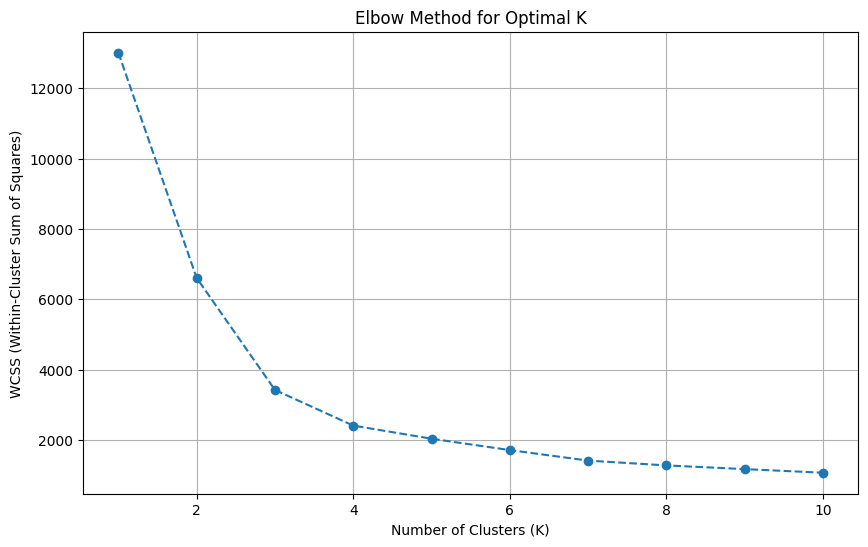

In [27]:
print("\n--- Determining Optimal K for K-Means ---")

# Elbow Method
wcss = []
for i in range(1, 11): # Test K from 1 to 10
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(rfm_scaled_df)
    wcss.append(kmeans.inertia_) # inertia_ is the WCSS

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

#### **Interpretation of the Elbow Method Plot:**
Looking at our plot, we are searching for the "elbow" point, which is where the rate of decrease in WCSS (Within-Cluster Sum of Squares) sharply changes, and then the curve starts to flatten out.

- **Initial Steep Drop:** From K=1 to K=2, and then from K=2 to K=3, there's a very steep drop in WCSS. This indicates that adding these initial clusters significantly reduces the variance within the clusters, meaning the data points are becoming much tighter around their centroids.

- **The "Elbow":** The most pronounced "bend" or "elbow" in the curve appears to be around **K = 3 or K = 4**.

    * The drop from K=2 to K=3 is still quite significant.

    * The drop from K=3 to K=4 is noticeable.

    * After K=4, the curve starts to flatten out more noticeably. The decrease in WCSS from K=4 to K=5, and onwards, is much less dramatic compared to the initial drops.

#### **Conclusion for Optimal K based on Elbow Method:**
Based purely on this Elbow Method plot, **K=3 or K=4** would be good candidates for the optimal number of clusters.

- **K=3:** Offers a good balance, capturing a significant reduction in WCSS without creating too many clusters.

- **K=4:** Also shows a good reduction and is where the curve begins to flatten more distinctly.

We should also consider **Silhouette Score** method

### **Silhouette Score Method**

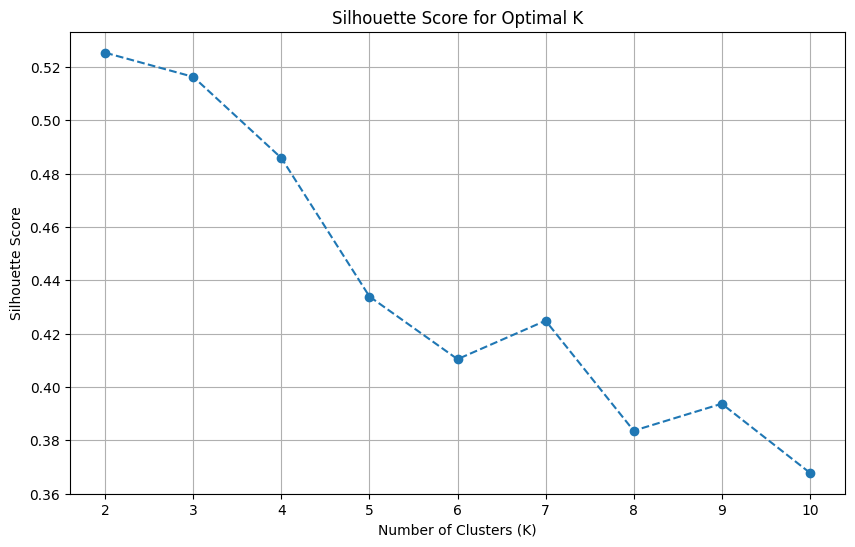

In [28]:
# Silhouette Score Method
silhouette_scores = []
for i in range(2, 11): # Silhouette score requires at least 2 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(rfm_scaled_df)
    score = silhouette_score(rfm_scaled_df, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

#### **Interpretation of the Silhouette Score Plot:**
Recall that a **higher Silhouette Score indicates better-defined clusters** (data points are well-matched to their own cluster and poorly matched to neighboring clusters). We are looking for the peak of this curve.

Looking at our plot:

- **Initial High Scores:** The Silhouette Score starts relatively high at K=2 (around 0.52) and K=3 (around 0.515).

- **Peak:** The highest Silhouette Score is observed at K = 2 (approximately 0.525).

- **Decreasing Trend:** After K=2, the score generally decreases, with a noticeable drop from K=3 to K=4, and then a more significant drop from K=4 to K=5.

- **Local Peak at K=7:** There's a slight increase from K=6 to K=7, forming a small local peak, but it's still significantly lower than the score at K=2 or K=3.

#### **Conclusion for Optimal K based on Silhouette Score:**
Based purely on this Silhouette Score plot, K = 2 would be considered the optimal number of clusters, as it yields the highest average silhouette score.

#### **Combining Elbow Method and Silhouette Score:**
- **Elbow Method:** Suggested K=3 or K=4 (where the curve started to flatten).

- **Silhouette Score:** Suggests K=2 (the highest score).

#### **Decision:**
K=4

**Reasoning for choosing K=4**, especially when considering the real-world application of customer segmentation for a marketing team:
- **Richer Understanding:** With four segments, we'll likely gain a more nuanced view of our customer base compared to just two. This allows for more granular insights into distinct behaviors.

- **Actionable Marketing:** We could segment the four cluster into "Big spending," "Regular spending," "Rarely spending," and "Moderately spending" customers and these clusters can directly translate into actionable marketing strategies. Marketing team can focus on "Rarely spending" and "Moderately spending" customers with targeted offers or discounts to encourage engagement and spending.

In machine learning, the "optimal" K isn't always determined solely by statistical metrics like the Silhouette Score. Business interpretability and the practical utility of the segments for decision-making are often equally, if not more, important. Our choice of K=4 aligns perfectly with creating a compelling and actionable project.

## 9. Clustering using K-Means Clustering

In [29]:
# Based on Elbow plot and our Decision to choose K=4 
optimal_k = 4
print(f"\nChosen optimal number of clusters (K): {optimal_k}")

# --- K-Means Clustering ---
print(f"\n--- Performing K-Means Clustering with K={optimal_k} ---")
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled_df)
print("Clustering complete. Cluster labels added to RFM DataFrame.")


Chosen optimal number of clusters (K): 4

--- Performing K-Means Clustering with K=4 ---
Clustering complete. Cluster labels added to RFM DataFrame.


In [30]:
# --- Cluster Analysis and Interpretation ---
print("\n--- Cluster Analysis ---")
# Calculate the mean RFM values for each cluster
cluster_profiles = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()
print("\nMean RFM values for each cluster:")
cluster_profiles


--- Cluster Analysis ---

Mean RFM values for each cluster:


,Cluster,Recency,Frequency,Monetary
0,0,51.702716,2.079012,605.177518
1,1,34.936269,5.929316,2243.538532
2,2,243.568665,1.478723,440.761853
3,3,17.682692,11.524038,4999.257800


In [31]:
# Sort clusters by Monetary value for better interpretation
cluster_profiles = cluster_profiles.sort_values(by='Monetary', ascending=False)
print("\nSorted Cluster Profiles (by Monetary value):")
cluster_profiles


Sorted Cluster Profiles (by Monetary value):


,Cluster,Recency,Frequency,Monetary
3,3,17.682692,11.524038,4999.257800
1,1,34.936269,5.929316,2243.538532
0,0,51.702716,2.079012,605.177518
2,2,243.568665,1.478723,440.761853


#### **Interpretation of Sorted Cluster Profiles (by Monetary Value):**
Based on these average RFM values for each cluster, we can now profile and name our customer segments. This aligns perfectly with our goal of creating actionable segments for our project.

Here's an interpretation and naming for each cluster:
1. **Cluster 3: Loyal Big Spenders**

    - **Recency (17.68 days):** Very low, meaning they purchased very recently. These are fresh customers.

    - **Frequency (11.52 purchases):** Very high, indicating they purchase frequently.

    - **Monetary (4999.26):** Extremely high, meaning they spend the most.

    - **Profile:** These are our most valuable customers. They buy often, spend a lot, and have purchased recently. They are highly engaged and loyal.

    - **Marketing Strategy:** Reward loyalty, offer exclusive previews/products, personalized recommendations for premium items, focus on retention and maximizing lifetime value.

2. **Cluster 1: Promising Regular Spenders**

    - **Recency (34.94 days):** Relatively low, meaning they are still quite recent.

    - **Frequency (5.93 purchases):** Good frequency, indicating they buy regularly.

    - **Monetary (2243.54):** High spending, but less than Cluster 3.

    - **Profile:** These customers are active and spend a good amount. They have the potential to become "Loyal Big Spenders" with the right nurturing.

    - **Marketing Strategy:** Encourage increased frequency and higher average order value. Cross-sell and up-sell relevant products, offer tiered loyalty benefits, send personalized product updates.

3. **Cluster 0: Occasional Spending Customers**

    - **Recency (51.70 days):** Moderate recency, indicating some time has passed since their last purchase.

    - **Frequency (2.08 purchases):** Low frequency, suggesting they are not frequent buyers.

    - **Monetary (605.18):** Moderate spending, but significantly less than Clusters 3 and 1.

    - **Profile:** These customers buy occasionally and spend a moderate amount. They might need a nudge to become more active.

    - **Marketing Strategy:** Re-engagement campaigns (if recency increases further), targeted promotions to increase purchase frequency, introduce new product lines, personalized offers based on past purchases to encourage repeat business.

4. **Cluster 2: At-Risk/Rarely Spending Customers**

    - **Recency (243.57 days):** Very high, meaning they have not purchased for a long time. These are inactive customers.

    - **Frequency (1.48 purchases):** Very low, often one-time buyers.

    - **Monetary (440.76):** Lowest spending among the clusters, likely reflecting their low frequency.

    - **Profile:** These customers are either one-time buyers who haven't returned, or they are at high risk of churning (or have already churned).

    - **Marketing Strategy:** Win-back campaigns, special discounts on their preferred categories, surveys to understand reasons for inactivity, re-activation offers. For very high recency, focus on re-acquiring rather than just retention.
  
This detailed profiling demonstrates a clear understanding of our customer base and how to leverage clustering for actionable marketing.

## 10. Visualizations of Clusters

In [32]:
warnings.filterwarnings("ignore", message="X does not have valid feature names, but PCA was fitted with feature names", 
                        category=UserWarning)

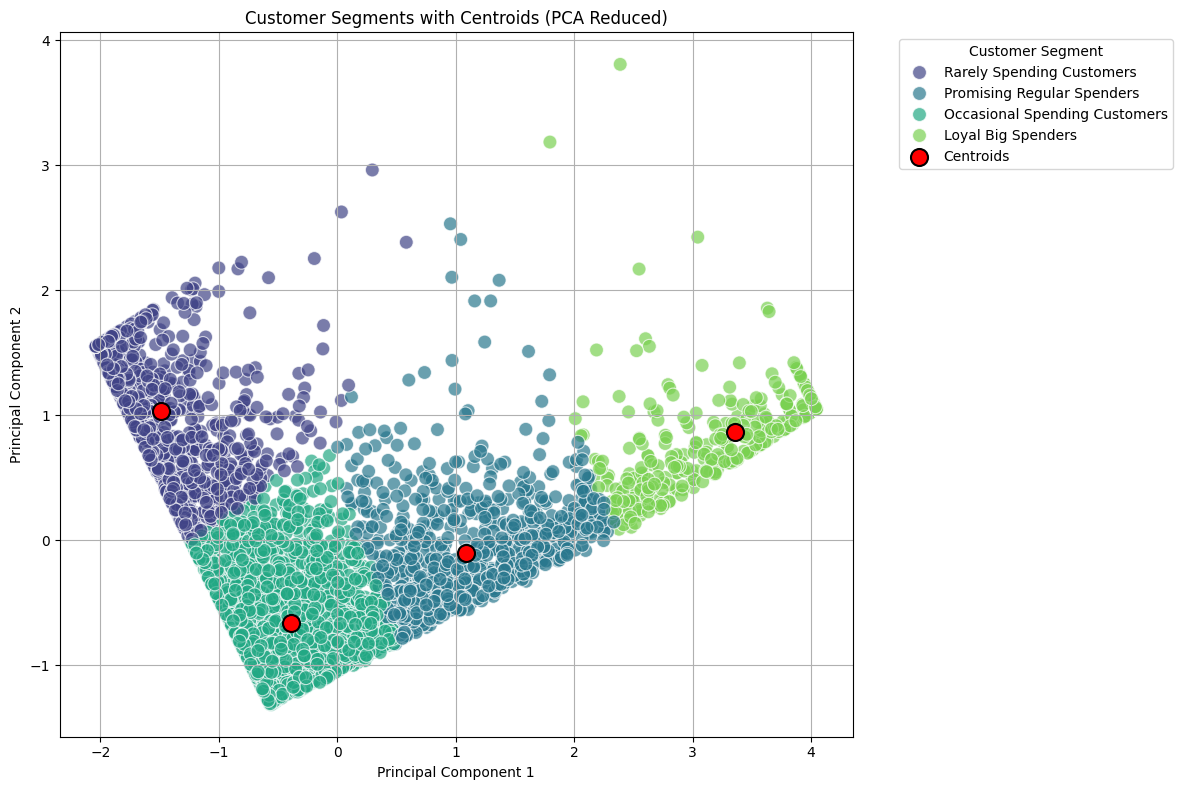

In [33]:
# Define a mapping from cluster number to descriptive name based on the sorted profiles
cluster_name_mapping = {
    3: "Loyal Big Spenders",
    1: "Promising Regular Spenders",
    0: "Occasional Spending Customers",
    2: "Rarely Spending Customers"
}

# Use PCA for dimensionality reduction to visualize in 2D
pca = PCA(n_components=2)
principal_components = pca.fit_transform(rfm_scaled_df)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
# Apply the cluster name mapping to the 'Cluster' column in pca_df
pca_df['Cluster_Name'] = rfm['Cluster'].map(cluster_name_mapping)

# Get the cluster centroids in the original scaled RFM space
centroids_scaled = kmeans.cluster_centers_
# Transform the centroids using the same PCA model
centroids_pca = pca.transform(centroids_scaled)
# Create a DataFrame for the PCA-transformed centroids
centroids_df = pd.DataFrame(data=centroids_pca, columns=['PC1', 'PC2'])
# Add cluster names to the centroids DataFrame
# Ensure the order of cluster_profiles matches the order of centroids (usually 0, 1, 2, 3)
# The cluster_profiles DataFrame is sorted by Monetary, so we need to get the original cluster IDs
original_cluster_ids = cluster_profiles['Cluster'].tolist()
# Sort the cluster_name_mapping by original cluster ID to match centroids_df order
sorted_cluster_names = [cluster_name_mapping[i] for i in sorted(cluster_name_mapping.keys())]
centroids_df['Cluster_Name'] = sorted_cluster_names

plt.figure(figsize=(12, 8))
# Plot the customer data points
sns.scatterplot(x='PC1', y='PC2', hue='Cluster_Name', data=pca_df, palette='viridis', s=100, alpha=0.7, legend='full')

# Plot the cluster centroids
sns.scatterplot(x='PC1', y='PC2', data=centroids_df, marker='o', s=150, color='red', edgecolor='black', linewidth=1.5, label='Centroids', zorder=5)

plt.title('Customer Segments with Centroids (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
# Combine legends: one for clusters, one for centroids
handles, labels = plt.gca().get_legend_handles_labels()
# Assuming the centroids legend is the last one added and has a specific label
# Reorder labels to put centroids at the end if desired, or just let Seaborn handle it
# If 'full' legend is used, Seaborn combines them.
plt.legend(title='Customer Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout() # Adjust layout to prevent legend overlap
plt.show()

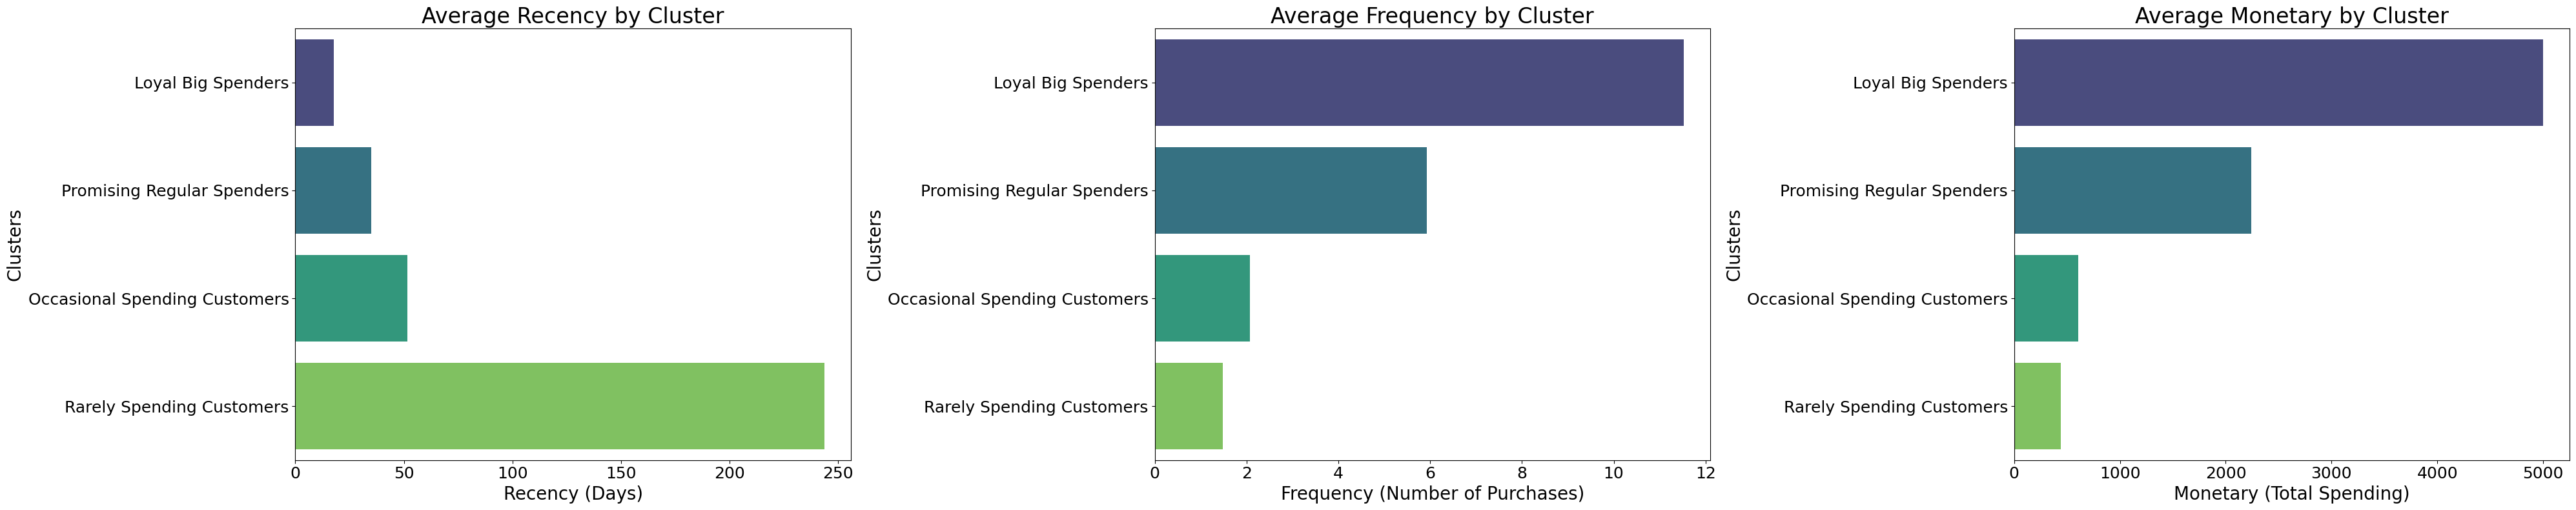

In [34]:
cluster_profiles['Cluster_Name'] = cluster_profiles['Cluster'].map(cluster_name_mapping)

# Bar plots to visualize RFM metrics across clusters
fig, axes = plt.subplots(1, 3, figsize=(40, 8))
sns.barplot(y='Cluster_Name', x='Recency', data=cluster_profiles, hue='Cluster_Name', ax=axes[0], palette='viridis', legend=False)
axes[0].set_title('Average Recency by Cluster', fontsize=24)
axes[0].set_xlabel('Recency (Days)',fontsize=20)
axes[0].set_ylabel('Clusters', fontsize=20)
axes[0].tick_params(axis='x', labelsize=18)
axes[0].tick_params(axis='y', labelsize=18)

sns.barplot(y='Cluster_Name', x='Frequency', data=cluster_profiles, hue='Cluster_Name', ax=axes[1], palette='viridis', legend=False)
axes[1].set_title('Average Frequency by Cluster', fontsize=24)
axes[1].set_xlabel('Frequency (Number of Purchases)', fontsize=20)
axes[1].set_ylabel('Clusters', fontsize=20)
axes[1].tick_params(axis='x', labelsize=18)
axes[1].tick_params(axis='y', labelsize=18)

sns.barplot(y='Cluster_Name', x='Monetary', data=cluster_profiles, hue='Cluster_Name', ax=axes[2], palette='viridis', legend=False)
axes[2].set_title('Average Monetary by Cluster', fontsize=24)
axes[2].set_xlabel('Monetary (Total Spending)', fontsize=20)
axes[2].set_ylabel('Clusters', fontsize=20)
axes[2].tick_params(axis='x', labelsize=18)
axes[2].tick_params(axis='y', labelsize=18)

plt.tight_layout()
plt.show()

## 11. Actionable Insights and Marketing Strategies

In [35]:
print("\n--- Actionable Insights and Marketing Strategies ---")
print("Based on the cluster profiles (mean RFM values) and visualizations, here are tailored marketing strategies for each segment:")

for index, row in cluster_profiles.iterrows():
    cluster_id = int(row['Cluster'])
    recency = row['Recency']
    frequency = row['Frequency']
    monetary = row['Monetary']
    cluster_name = cluster_name_mapping.get(cluster_id, "Unknown Segment") # Get the descriptive name

    print(f"\n--- Cluster {cluster_id}: {cluster_name} ---")
    print(f"  Average Recency: {recency:.2f} days")
    print(f"  Average Frequency: {frequency:.2f} purchases")
    print(f"  Average Monetary: ${monetary:.2f}")


--- Actionable Insights and Marketing Strategies ---
Based on the cluster profiles (mean RFM values) and visualizations, here are tailored marketing strategies for each segment:

--- Cluster 3: Loyal Big Spenders ---
  Average Recency: 17.68 days
  Average Frequency: 11.52 purchases
  Average Monetary: $4999.26

--- Cluster 1: Promising Regular Spenders ---
  Average Recency: 34.94 days
  Average Frequency: 5.93 purchases
  Average Monetary: $2243.54

--- Cluster 0: Occasional Spending Customers ---
  Average Recency: 51.70 days
  Average Frequency: 2.08 purchases
  Average Monetary: $605.18

--- Cluster 2: Rarely Spending Customers ---
  Average Recency: 243.57 days
  Average Frequency: 1.48 purchases
  Average Monetary: $440.76


#### **Cluster 3: Loyal Big Spenders**
- **Average Recency:** 17.68 days
- **Average Frequency:** 11.52 purchases
- **Average Monetary:** $4999.26
- **Strategy:** These are our most valuable and engaged customers. Focus on **retention, appreciation, and maximizing their lifetime value.**
    * **Exclusive Offers:** Provide early access to new products, VIP discounts, or exclusive bundles.
    * **Loyalty Programs:** Enhance their loyalty benefits, perhaps with higher tiers or personalized rewards.
    * **Personalized Recommendations:** Leverage their purchase history for highly relevant product suggestions.
    * **Feedback & Engagement:** Solicit their feedback for product development and involve them in community events.
    * **Customer Service:** Ensure top-tier, proactive customer support.

#### **Cluster 1: Promising Regular Spenders**
- **Average Recency:** 34.94 days
- **Average Frequency:** 5.93 purchases
- **Average Monetary:** $2243.54
- **Strategy:** These customers are active and valuable, with potential to become 'Loyal Big Spenders.' Focus on **increasing their frequency and average order value.**
    * **Cross-selling & Up-selling:** Recommend complementary or higher-value products based on past purchases.
    * **Tiered Rewards:** Introduce them to loyalty program tiers that incentivize slightly higher spending or more frequent purchases.
    * **Product Education:** Highlight features or benefits of products they might be interested in to encourage deeper engagement.
    * **Timely Reminders:** Gentle nudges for re-purchase of consumables or seasonal items.

#### **Cluster 0: Occasional Spending Customers**
- **Average Recency:** 51.70 days
- **Average Frequency:** 2.08 purchases
- **Average Monetary:** $605.18
- **Strategy:** These customers buy occasionally. The goal is to **increase their purchase frequency and re-engage them more consistently.**
    * **Targeted Promotions:** Offer discounts or bundles on product categories they've shown interest in, or on popular items.
    * **Re-engagement Campaigns:** If their recency starts to increase, send personalized emails or notifications to bring them back (e.g., 'We miss you' offers).
    * **New Product Introductions:** Showcase new arrivals that align with their past preferences to spark new interest.
    * **Value Proposition Reinforcement:** Remind them of the benefits of shopping with you (e.g., free shipping thresholds, loyalty points).

#### **Cluster 2: Rarely Spending Customers**
- **Average Recency:** 243.57 days
- **Average Frequency:** 1.48 purchases
- **Average Monetary:** $440.76
- **Strategy:** These customers are either one-time buyers or are on the verge of churning. Focus on **re-activation and understanding their reasons for inactivity.**
    * **Win-Back Campaigns:** Offer significant discounts or compelling incentives to encourage a return purchase.
    * **Feedback Surveys:** Send short surveys to understand why they haven't purchased recently (e.g., 'How can we improve?').
    * **Product Re-discovery:** Highlight popular or trending products that might pique their interest, even if not directly related to past purchases.
    * **Brand Re-introduction:** Remind them of your brand's core values or recent improvements.
    * **Consider Acquisition:** For very long inactive customers, the cost of re-acquisition might be similar to acquiring a new customer.

These tailored strategies leverage customer segmentation to drive more effective marketing efforts.

## 12. Project Conclusion: Online Retail Customer Segmentation
This project successfully demonstrated a comprehensive unsupervised machine learning pipeline for customer segmentation using the "Online Retail" transactional dataset. The primary goal was to identify distinct customer groups to enable more targeted and effective marketing strategies.

#### **Key Steps and Achievements:**
1. **Data Loading and Comprehensive EDA:**

    - The project began with loading the "OnlineRetail.csv" dataset, addressing potential encoding issues.

    - A thorough Exploratory Data Analysis (EDA) was performed, including `df.info()`, `df.describe()`, missing value analysis, and statistical summaries of categorical features.

    - Crucially, visualizations (histograms and box plots) for `Quantity`, `UnitPrice`, and `TotalPrice` were generated after a `log1p` transformation to effectively handle their highly skewed distributions and reveal underlying patterns. This provided a clear understanding of the data's characteristics and the presence of outliers.

2. **Data Preprocessing:**

    - Essential data cleaning steps were implemented, including dropping rows with missing `CustomerID`, removing canceled orders (identified by 'C' in `InvoiceNo`), converting `InvoiceDate` to datetime objects, calculating `TotalPrice`, and filtering out transactions with non-positive `Quantity` or `UnitPrice`. This ensured a clean and valid dataset for analysis.

3. **RFM Feature Engineering:**

    - The core of the segmentation was built upon Recency, Frequency, and Monetary (RFM) analysis. These powerful marketing metrics were engineered from the transactional data, providing a concise summary of each customer's purchasing behavior.

    - Outlier treatment was applied to the RFM features by capping values at the 5th and 95th percentiles. This was a critical step to mitigate the disproportionate influence of extreme values on the clustering algorithm while retaining the majority of the data's information.

    - The RFM features were then scaled using `StandardScaler` to ensure that no single feature dominated the distance calculations during clustering.

4. **Optimal Cluster Determination and K-Means Clustering:**

    - The Elbow Method and Silhouette Score were employed to guide the selection of the optimal number of clusters (K). While the Silhouette Score suggested K=2, the Elbow Method indicated K=3 or K=4.

    - Based on the desire for a richer, more actionable understanding of customer segments for a marketing team, **K=4** was chosen as the optimal number of clusters.

    - K-Means clustering was then applied to the scaled RFM data, assigning each customer to one of the four identified segments.

5. **Cluster Analysis and Visualization:**

    - The mean RFM values for each cluster were calculated and analyzed to profile the characteristics of each segment.

    - Visualizations were created to effectively present the results:

        * A PCA-reduced scatter plot showed the spatial distribution of customers in 2D, with cluster centroids clearly marked and the legend displaying descriptive segment names (e.g., "Loyal Big Spenders") for intuitive understanding.

        * Bar plots illustrated the average Recency, Frequency, and Monetary values for each cluster, further clarifying their distinct profiles.

#### **Actionable Insights and Marketing Strategies:**
The project successfully identified four distinct customer segments, each with tailored marketing implications:

- **Cluster 3: Loyal Big Spenders (Champions)**

    * **Profile:** Very recent, highly frequent, extremely high spending. Your most valuable customers.

    * **Strategy:** Focus on retention, appreciation, exclusive offers, loyalty programs, and personalized premium recommendations.

- **Cluster 1: Promising Regular Spenders (At-Potential)**

    * **Profile:** Relatively recent, good frequency, high spending. Active and valuable with growth potential.

    * **Strategy:** Encourage increased frequency and average order value through cross-selling, up-selling, and tiered rewards.

- **Cluster 0: Occasional Spending Customers (Needs Nurturing)**

    * **Profile:** Moderate recency, low frequency, moderate spending. Buy occasionally.

    * **Strategy:** Increase purchase frequency and re-engage consistently with targeted promotions, re-engagement campaigns, and new product introductions.

- **Cluster 2: Rarely Spending Customers (Churning)**

    - **Profile:** Very high recency, very low frequency, lowest spending. One-time buyers or inactive.

    - **Strategy:** Focus on re-activation through win-back campaigns, feedback surveys, and re-introduction to the brand.

#### **Overall Value:**
This project demonstrates proficiency in data cleaning, feature engineering, unsupervised machine learning (clustering), and data visualization. More importantly, it showcases the ability to translate complex data analysis into clear, actionable business insights, which is invaluable for any data science portfolio. The identified customer segments provide a solid foundation for businesses to optimize their marketing spend, improve customer retention, and drive revenue growth.